In [1]:
import os
import sys
import numpy as np
import scipy
import torch
import monai

from matplotlib import pyplot as plt

sys.path.append("/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/src")
from custom_losses import MultiScaleDice, DiceLoss_noSmooth 

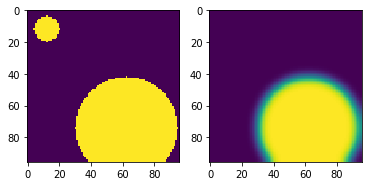

In [2]:
# create a 2D fake examples
size_x, size_y = 96, 96
cx1, cy1 = 74, 62
r1 = 32
cx2, cy2 = 12, 12
r2 = 8

ground_truth = np.zeros([size_x, size_y])
# add first circle
y1, x1 = np.ogrid[-cx1:size_x-cx1, -cy1:size_y-cy1]
mask1 = x1*x1 + y1*y1 <= r1*r1
ground_truth[mask1] = 1.0
# add second circle
y2, x2 = np.ogrid[-cx2:size_x-cx2, -cy2:size_y-cy2]
mask2 = x2*x2 + y2*y2 <= r2*r2
ground_truth[mask2] = 1.0

net_out = np.zeros([size_x, size_y])
net_out[mask1] = 1.0
net_out = scipy.ndimage.gaussian_filter(net_out, sigma=3)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(ground_truth, vmin=0.0, vmax=1.0, interpolation='nearest')
ax[1].imshow(net_out, vmin=0.0, vmax=1.0, interpolation='nearest')

torch.Size([1, 1, 96, 96])
torch.Size([1, 1, 48, 48])
torch.Size([1, 1, 24, 24])
torch.Size([1, 1, 12, 12])


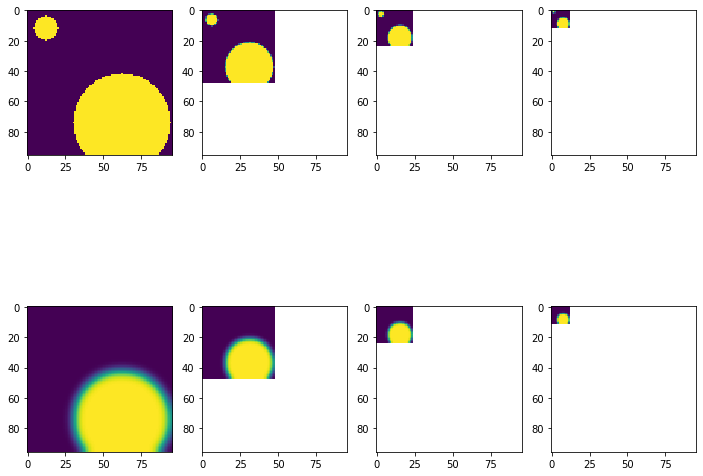

In [3]:
# check effect of average pooling
number_of_scales = 4
gt_tensor = torch.as_tensor(np.ascontiguousarray(ground_truth))
gt_tensor = gt_tensor[None, None]
print(gt_tensor.shape)
out_tensor = torch.as_tensor(np.ascontiguousarray(net_out))
out_tensor = out_tensor[None, None]
avg_pool_fn = torch.nn.AvgPool2d(kernel_size=2, stride=2)

final_size = np.asarray(list(gt_tensor.shape))[2:] / (2 ** number_of_scales)
assert (np.all(final_size >= 1)), f"selected number or scales is too big compared to the input size)"

fig_avg, ax_avg = plt.subplots(nrows=2, ncols=number_of_scales, figsize=(12, 10))
ax_avg[0, 0].imshow(gt_tensor.numpy()[0, 0, :], vmin=0.0, vmax=1.0, interpolation='nearest')
ax_avg[1, 0].imshow(out_tensor.numpy()[0, 0, :], vmin=0.0, vmax=1.0, interpolation='nearest')
for s in range(number_of_scales-1):
    gt_tensor = avg_pool_fn(gt_tensor)
    out_tensor = avg_pool_fn(out_tensor)
    print(out_tensor.shape)
    ax_avg[0, s+1].imshow(gt_tensor.numpy()[0, 0, :], vmin=0.0, vmax=1.0, interpolation='nearest')
    ax_avg[0, s+1].set_ylim(ax_avg[0, 0].get_ylim())
    ax_avg[0, s+1].set_xlim(ax_avg[0, 0].get_xlim())
    ax_avg[1, s+1].imshow(out_tensor.numpy()[0, 0, :], vmin=0.0, vmax=1.0, interpolation='nearest')
    ax_avg[1, s+1].set_ylim(ax_avg[1, 0].get_ylim())
    ax_avg[1, s+1].set_xlim(ax_avg[1, 0].get_xlim())
    

In [4]:
do_sigmoid, do_softmax = False, False
smooth = 1e-5

gt_tensor = torch.as_tensor(np.ascontiguousarray(ground_truth))
gt_tensor = gt_tensor[None, None]
out_tensor = torch.as_tensor(np.ascontiguousarray(net_out))
out_tensor = out_tensor[None, None]

loss_function_2 = DiceLoss_noSmooth(do_sigmoid=do_sigmoid, do_softmax=do_softmax)
dice_2 = loss_function_2(out_tensor, gt_tensor, smooth=smooth)
print(f"Simple Dice Loss: {dice_2}\n")

loss_function_3 = monai.losses.DiceLoss(sigmoid=do_sigmoid, softmax=do_softmax)
dice_3 = loss_function_3(out_tensor, gt_tensor, smooth=smooth)
print(f"MONAI Dice Loss: {dice_3}\n")

loss_function = MultiScaleDice(dimensions=2, number_of_scales=4, do_sigmoid=do_sigmoid, do_softmax=do_softmax)
dice_multiscale = loss_function(out_tensor, gt_tensor, smooth)
print(f"Final multiscale dice is: {dice_multiscale}\n")

print(out_tensor.shape)

Simple Dice Loss: 0.09159671225176802

MONAI Dice Loss: 0.09159671056514307

tensor(0.0916, dtype=torch.float64)
tensor(0.0933, dtype=torch.float64)
tensor(0.0990, dtype=torch.float64)
tensor(0.1199, dtype=torch.float64)
Final multiscale dice is: 0.1009389213472601

torch.Size([1, 1, 96, 96])


In [5]:
gt_flatten = ground_truth.flatten()
out_flatten = net_out.flatten()
dice_numpy = 1 - (2 * np.sum(gt_flatten * out_flatten)) /(np.sum(gt_flatten) + np.sum(out_flatten) + 1e-5)
print(dice_numpy)

0.09159671225176824
